In [1]:
# !pip install jovian --upgrade -q
# import jovian
# jovian.set_project('fashion-feedforward-minimal')

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [3]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

C:\Users\yashr\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds , val_ds = random_split(dataset , [train_size , val_size])
len(train_ds) , len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

In [6]:
train_loader = DataLoader(train_ds , batch_size , shuffle=True , num_workers = 2 , pin_memory=True)
val_loader = DataLoader(val_ds , batch_size*2 , num_workers = 2 , pin_memory = True)

torch.Size([1, 28, 28])
tensor([7, 7, 9, 8, 3, 4, 7, 1, 4, 3, 8, 9, 4, 9, 3, 2, 0, 1, 8, 8, 3, 8, 2, 8,
        2, 0, 0, 7, 1, 8, 6, 1, 7, 1, 7, 8, 3, 9, 8, 7, 4, 2, 3, 9, 5, 7, 2, 6,
        2, 7, 9, 8, 9, 8, 7, 0, 5, 8, 5, 9, 7, 6, 7, 5, 2, 4, 1, 1, 5, 9, 2, 7,
        8, 5, 8, 1, 4, 8, 0, 5, 3, 6, 3, 7, 8, 4, 6, 7, 4, 7, 9, 9, 6, 7, 4, 9,
        1, 3, 7, 9, 0, 5, 6, 9, 3, 1, 1, 0, 9, 8, 9, 5, 4, 5, 4, 6, 6, 2, 5, 4,
        5, 7, 5, 2, 6, 9, 4, 0])


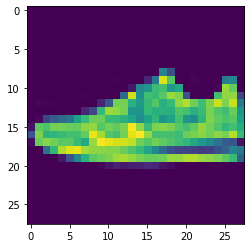

In [7]:
for images , labels in train_loader:
    print(images[0].shape)
    print(labels)
    plt.imshow(images[0].permute(1,2,0))
    break

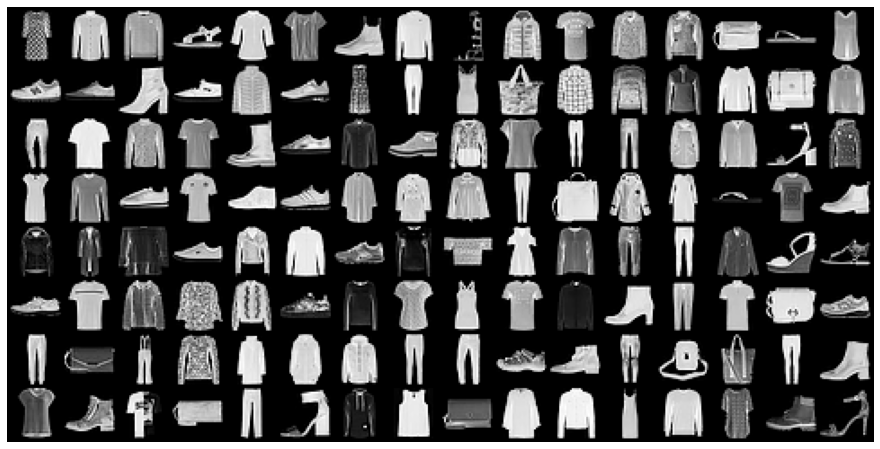

In [8]:
for images , _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images , nrow = 16).permute(1,2,0))
    break

In [9]:
def accuracy(outputs , labels):
    _ , preds = torch.max(outputs , dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/ len(preds))

In [10]:
class MNISTmodel(nn.Module):
    
    def __init__(self, input_size , output_size):
        super().__init__()
        self.Linear1 = nn.Linear(input_size , 128)
        self.Linear2 = nn.Linear(128,32)
        self.Linear3 = nn.Linear(32,output_size)
    
    def forward(self , images):
        out = images.view(images.size(0) , -1)
        out = self.Linear1(out)
        out = F.relu(out)
        out = self.Linear2(out)
        out = F.relu(out)
        out = self.Linear3(out)
        return out
    
    def training_step(self , batch):
        images , labels = batch
        out = self(images)
        loss = F.cross_entropy(out , labels)
        return loss
    
    def validation_step(self, batch):
        images , labels = batch
        out = self(images)
        loss = F.cross_entropy(out , labels)
        acc = accuracy(out , labels)
        return {'val_loss': loss , 'val_acc': acc}
    
    def validation_epoch_end(self , outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self , epoch , result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
        

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
def to_device(data , device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device , non_blocking=True)

In [14]:
class DeviceDataLoader():
    def __init__(self , dl , device):
        self.dl = dl;
        self.device = device;
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b , device)
            
    def __len__(self):
        return len(self.dl)

In [15]:
train_loader = DeviceDataLoader(train_loader , device)
val_loader = DeviceDataLoader(val_loader , device)
test_loader = DeviceDataLoader( DataLoader(test_dataset , batch_size*2 , num_workers = 4 , pin_memory = True) , device)

In [16]:
def evaluate(model , val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model , lr , epochs , train_loader , val_loader , opt_func=torch.optim.SGD ):
    history = []
    optimiser = opt_func(model.parameters() , lr)
    
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            
        result = evaluate(model , val_loader)
        model.epoch_end(epoch , result)
        history.append(result)
    return history

In [17]:
model = MNISTmodel(784 , 10)
to_device(model , device)

MNISTmodel(
  (Linear1): Linear(in_features=784, out_features=128, bias=True)
  (Linear2): Linear(in_features=128, out_features=32, bias=True)
  (Linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
history = [evaluate(model , val_loader)]
history

[{'val_loss': 2.3033177852630615, 'val_acc': 0.09785155951976776}]

In [19]:
history += fit(model , 0.1 , 5 , train_loader , val_loader )

Epoch [0], val_loss: 0.6770, val_acc: 0.7478
Epoch [1], val_loss: 0.4865, val_acc: 0.8340
Epoch [2], val_loss: 0.4540, val_acc: 0.8408
Epoch [3], val_loss: 0.5304, val_acc: 0.8026
Epoch [4], val_loss: 0.3944, val_acc: 0.8575


In [20]:
history += fit(model , 0.01 , 5 , train_loader , val_loader )

Epoch [0], val_loss: 0.3679, val_acc: 0.8711
Epoch [1], val_loss: 0.3662, val_acc: 0.8694
Epoch [2], val_loss: 0.3612, val_acc: 0.8709
Epoch [3], val_loss: 0.3606, val_acc: 0.8705
Epoch [4], val_loss: 0.3604, val_acc: 0.8726


In [21]:
history += fit(model , 0.001 , 5 , train_loader , val_loader )

Epoch [0], val_loss: 0.3575, val_acc: 0.8721
Epoch [1], val_loss: 0.3571, val_acc: 0.8721
Epoch [2], val_loss: 0.3570, val_acc: 0.8720
Epoch [3], val_loss: 0.3571, val_acc: 0.8728
Epoch [4], val_loss: 0.3567, val_acc: 0.8724


In [22]:
evaluate(model , val_loader)

{'val_loss': 0.35667333006858826, 'val_acc': 0.872363269329071}

In [26]:
def predict_image(model , image):
    image = to_device(image.unsqueeze(0) , device)
    output = model(image)
    _ , preds = torch.max(output , dim=1)
    return preds[0].item()

In [28]:
len(test_dataset)

10000

Label :  Ankle boot , Predicted :  Ankle boot


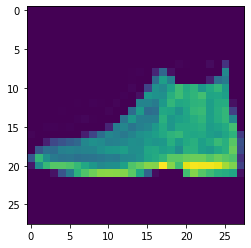

In [27]:
img , label = test_dataset[0]
plt.imshow(img.permute(1,2,0))
print('Label : ', dataset.classes[label] , ', Predicted : ' , dataset.classes[predict_image(model , img)])

Label :  Bag , Predicted :  Bag


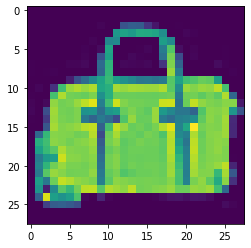

In [29]:
img , label = test_dataset[9732]
plt.imshow(img.permute(1,2,0))
print('Label : ', dataset.classes[label] , ', Predicted : ' , dataset.classes[predict_image(model , img)])

In [30]:
saved_weights_fname='fashion-feedforward.pth'

In [31]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.38777855038642883, 'val_acc': 0.861035168170929}

In [32]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_loss'])

[jovian] Metrics logged.


In [34]:
torch.save(model.state_dict(), saved_weights_fname)

In [35]:
jovian.commit(project='fashion-feedforward-minimal', 
              environment=None, 
              outputs=[saved_weights_fname])

<IPython.core.display.Javascript object>

[jovian] Creating a new project "yashrsakaria1/fashion-feedforward-minimal"
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/yashrsakaria1/fashion-feedforward-minimal


'https://jovian.ai/yashrsakaria1/fashion-feedforward-minimal'